In [14]:
import pandas as pd
import matplotlib.pyplot as plt
#Import CSV
#colnames, as they are not specified in DS
pd.options.display.max_columns = 50
colnames = ["id", "age", "gender", "education", "country", "ethnicity", 
            "neuroticism", "extraversion", "openness", "agreeableness",
           "conscientiousness", "impulsiveness", "sensation_seeking",
           "alcohol", "amphet", "amyl", "benzos", "caff", "cannabis",
           "choc", "coke", "crack", "ecstasy", "heroin", "ketamine",
           "legalh", "lsd", "meth", "mushrooms", "nicotine", "semer", "vsa"]
drugs = pd.read_csv('data/drug_consumption.csv', header = None, names = colnames, index_col = False)

# preprocessing (reverse transformation)
#relabelling from web source
age = {-0.07854: "25-34", -0.95197: "18-24", 2.59171: "65+", 1.82213: "55-64", 1.09449: "45-54", 0.49788: "35-45"}
gender = {0.48246: "Female", -0.48246: "Male"}
education = {-1.43719: "Left school at 17 years", -1.73790: "Left school at 16 years", -2.43591: "Left school before 16 years",
           0.45468: "University degree", -0.05921: "Professional certificate/ diploma", -0.61113: "Some college or university, no certificate or degree",
           -1.22751: "Left school at 18 years", 1.98437: "Doctorate degree", 1.16365: "Masters degree"}
country = {0.21128: "Republic of Ireland", -0.28519: "Other", -0.46841: "New Zealand", 0.24923: "Canada",
          -0.09765: "Australia", -0.57009: "USA", 0.96082: "UK"}
ethnicity = {-0.31685: "White", 0.11440: "Other", -0.22166: "Mixed-White/Black", 0.12600: "Mixed-White/Asian",
           1.90725: "Mixed-Black/Asian", -1.10702: "Black", -0.50212: "Asian"}

# rounding error must be corrected: website only contains 5 decimal numbers
drugs.age = round(drugs.age,5)
drugs.age = drugs.age.replace(age.keys(), age.values())
drugs.gender = round(drugs.gender, 5)
drugs.gender = drugs.gender.replace(gender.keys(), gender.values())
drugs.education = round(drugs.education, 5)
drugs.education = drugs.education.replace(education.keys(), education.values())
drugs.country = round(drugs.country, 5)
drugs.country = drugs.country.replace(country.keys(), country.values())
drugs.ethnicity = round(drugs.ethnicity, 5)
drugs.ethnicity = drugs.ethnicity.replace(ethnicity.keys(), ethnicity.values())

drugs.head()

#list of dicts for reverse transformation of the other variables
#these variables have more possible values, so it would be very time
#intense to do that manually as well
label_list = []
#extract informatioin from txt file created from web source
with open("data/drug_data-description.txt", "r") as file:
    data = file.readlines()
    for line in data:
        ### if line start with digit -> new variable section begins
        if line[0].isdigit():
            ### create new dict in list for each variable
            label_list.append(dict())
        ### only lines starting with <br> contain information
        if line[0:4] == "<br>":
            ### get clean numbers out of line
            numbers = line.split()[1:]
            #transform them from str to numeric
            for i in range(len(numbers)):
                if numbers[i].isdigit():
                    numbers[i] = int(numbers[i])
                else:
                    numbers[i] = float(numbers[i])
            ### append needed values to last (current) dict in list
            if len(numbers) == 6:
                numbers.pop(1)
                numbers.pop(3)
            if len(numbers) == 9:
                numbers.pop(1)
                numbers.pop(3)
                numbers.pop(5)
            for i in range(1, len(numbers), 2):
                label_list[len(label_list)-1][numbers[i]] = numbers[i-1]

## retransform variables according to dict
for i in range(len(label_list)):
    drugs.iloc[:,i+6] = round(drugs.iloc[:, i+6], 5)
    drugs.iloc[:,i+6] = drugs.iloc[:,i+6].replace(label_list[i].keys(), label_list[i].values())

#change data types
for i in range(1, 6):
    drugs[colnames[i]] = drugs[colnames[i]].astype("category")
for i in range(6, 11):
    drugs[colnames[i]] = drugs[colnames[i]].astype("int32")
    
#########takes some time
#### removing "CL*"    
for i in range(13, len(colnames)):
    for j in range(0, len(drugs[colnames[i]])):
        drugs.iloc[j,i] = int(drugs.iloc[j,i][-1])
drugs.head()

for i in range(13, len(colnames)):
    drugs[colnames[i]] = drugs[colnames[i]].astype("category")
print(drugs.info())
print(drugs.head())

,id,age,gender,education,country,ethnicity,neuroticism,extraversion,openness,agreeableness,conscientiousness,impulsiveness,sensation_seeking,alcohol,amphet,amyl,benzos,caff,cannabis,choc,coke,crack,ecstasy,heroin,ketamine,legalh,lsd,meth,mushrooms,nicotine,semer,vsa
0,1,0.49788,0.48246,-0.05921,0.96082,0.12600,0.31287,-0.57545,-0.58331,-0.91699,-0.00665,-0.21712,-1.18084,CL5,CL2,CL0,CL2,CL6,CL0,CL5,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL2,CL0,CL0
1,2,-0.07854,-0.48246,1.98437,0.96082,-0.31685,-0.67825,1.93886,1.43533,0.76096,-0.14277,-0.71126,-0.21575,CL5,CL2,CL2,CL0,CL6,CL4,CL6,CL3,CL0,CL4,CL0,CL2,CL0,CL2,CL3,CL0,CL4,CL0,CL0
2,3,0.49788,-0.48246,-0.05921,0.96082,-0.31685,-0.46725,0.80523,-0.84732,-1.62090,-1.01450,-1.37983,0.40148,CL6,CL0,CL0,CL0,CL6,CL3,CL4,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL0,CL1,CL0,CL0,CL0
3,4,-0.95197,0.48246,1.16365,0.96082,-0.31685,-0.14882,-0.80615,-0.01928,0.59042,0.58489,-1.37983,-1.18084,CL4,CL0,CL0,CL3,CL5,CL2,CL4,CL2,CL0,CL0,CL0,CL2,CL0,CL0,CL0,CL0,CL2,CL0,CL0
4,5,0.49788,0.48246,1.98437,0.96082,-0.31685,0.73545,-1.63340,-0.45174,-0.30172,1.30612,-0.21712,-0.21575,CL4,CL1,CL1,CL0,CL6,CL3,CL6,CL0,CL0,CL1,CL0,CL0,CL1,CL0,CL0,CL2,CL2,CL0,CL0


## 3 Statistical Analysis

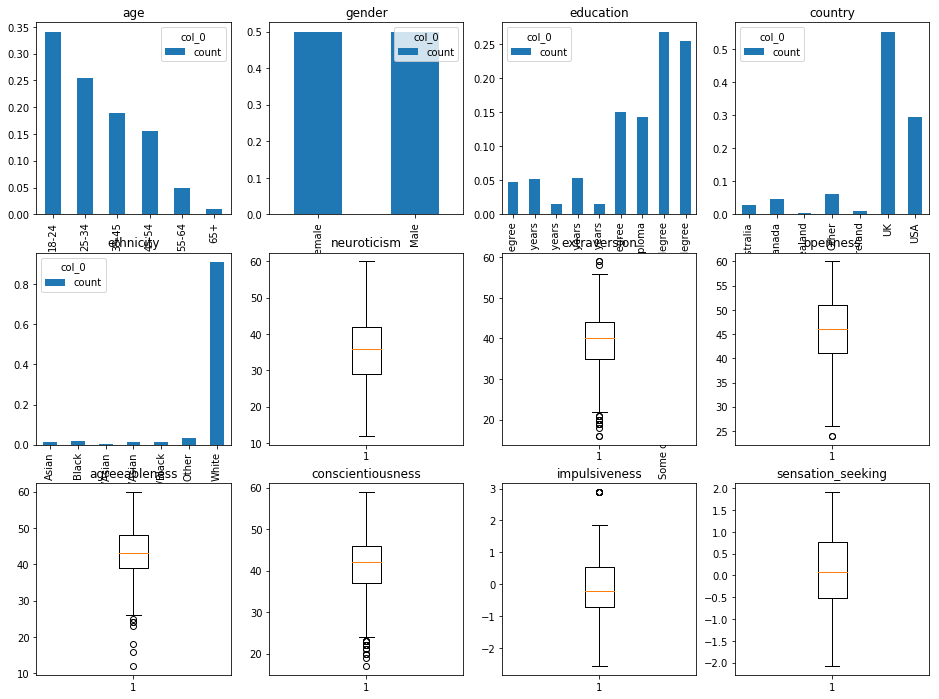

In [7]:
fig, axlist = plt.subplots(3,4,figsize=(16,12))
variable = 1
for row in range(0,3):
    for i in range(0,4):
        if drugs[colnames[variable]].dtype == "int32" or drugs[colnames[variable]].dtype == "float64":
            axlist[row][i].boxplot(drugs[colnames[variable]])
            axlist[row][i].set_title(colnames[variable])
        else:
            tab = pd.crosstab(drugs[colnames[variable]], columns="count")
            rel_tab = tab/tab.sum()
            rel_tab.plot(kind = "bar", ax = axlist[row][i])
            axlist[row][i].set_title(colnames[variable])
        variable += 1

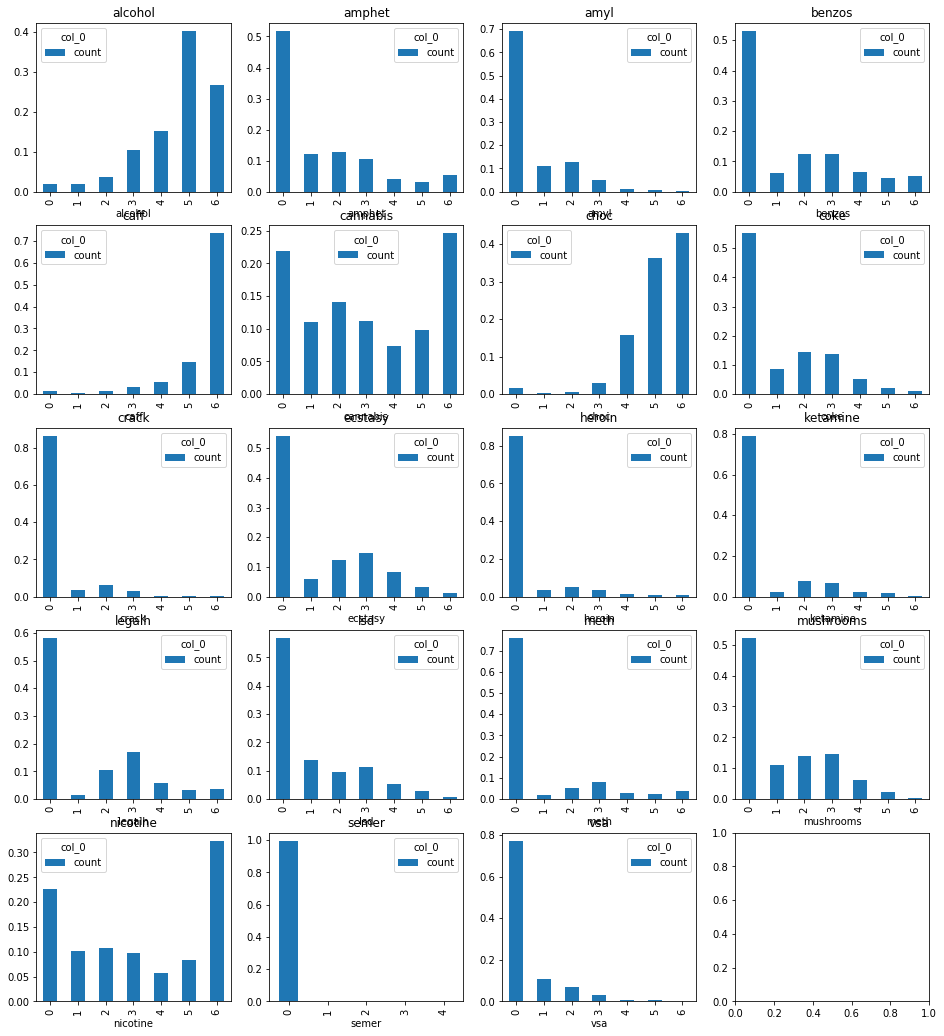

In [24]:
fig, axlist = plt.subplots(5,4,figsize=(16,18))
for row in range(0,5):
    for i in range(0,4):
        tab = pd.crosstab(drugs[colnames[variable]], columns="count")
        rel_tab = tab/tab.sum()
        rel_tab.plot(kind = "bar", ax = axlist[row][i])
        axlist[row][i].set_title(colnames[variable])
        if variable == 31:
            break
        variable += 1

In [7]:
drugs.isna().sum() # The number of missing values per Attribute (column)

id                   0
age                  0
gender               0
education            0
country              0
ethnicity            0
neuroticism          0
extraversion         0
openness             0
agreeableness        0
conscientiousness    0
impulsiveness        0
sensation_seeking    0
alcohol              0
amphet               0
amyl                 0
benzos               0
caff                 0
cannabis             0
choc                 0
coke                 0
crack                0
ecstasy              0
heroin               0
ketamine             0
legalh               0
lsd                  0
meth                 0
mushrooms            0
nicotine             0
semer                0
vsa                  0
dtype: int64

In [8]:
drugs.shape # Check dimensions

(1885, 32)

In [9]:
drugs.iloc[:,1:].describe() #without id

,neuroticism,extraversion,openness,agreeableness,conscientiousness,impulsiveness,sensation_seeking
count,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,35.921485,39.576127,45.762334,42.866313,41.437135,0.007216,-0.003292
std,9.135869,6.771769,6.579641,6.438106,6.966625,0.954435,0.963701
min,12.000000,16.000000,24.000000,12.000000,17.000000,-2.555240,-2.078480
25%,29.000000,35.000000,41.000000,39.000000,37.000000,-0.711260,-0.525930
50%,36.000000,40.000000,46.000000,43.000000,42.000000,-0.217120,0.079870
75%,42.000000,44.000000,51.000000,48.000000,46.000000,0.529750,0.765400
max,60.000000,59.000000,60.000000,60.000000,59.000000,2.901610,1.921730


There is no statistical summary for categorical data. We can get a summary of the categorical variables by passing only those columns to describe():

In [8]:
categorical = drugs.dtypes[drugs.dtypes == "category"].index #gives list of attributes that are categorical
drugs[categorical].describe()

,age,gender,education,country,ethnicity,alcohol,amphet,amyl,benzos,caff,cannabis,choc,coke,crack,ecstasy,heroin,ketamine,legalh,lsd,meth,mushrooms,nicotine,semer,vsa
count,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885,1885
unique,6,2,9,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,7,5,7
top,18-24,Male,"Some college or university, no certificate or ...",UK,White,5,0,0,0,6,6,6,0,0,0,0,0,0,0,0,0,6,0,0
freq,643,943,506,1044,1720,759,976,1305,1000,1385,463,807,1038,1627,1021,1605,1490,1094,1069,1429,982,610,1877,1455


In [11]:
#list of proportional frequency tables
prop_tables = []
for variable in categorical:
    tab = pd.crosstab(drugs[variable], columns="count")
    rel_tab = tab/tab.sum()
    prop_tables.append(rel_tab)

print(categorical)

for i in [0, 2, 5, 14]:
    print(prop_tables[i])
    print()
    

Index(['age', 'gender', 'education', 'country', 'ethnicity', 'alcohol',
       'amphet', 'amyl', 'benzos', 'caff', 'cannabis', 'choc', 'coke', 'crack',
       'ecstasy', 'heroin', 'ketamine', 'legalh', 'lsd', 'meth', 'mushrooms',
       'nicotine', 'semer', 'vsa'],
      dtype='object')
col_0     count
age            
18-24  0.341114
25-34  0.255172
35-45  0.188859
45-54  0.155968
55-64  0.049337
65+    0.009549

col_0                                                  count
education                                                   
Doctorate degree                                    0.047215
Left school at 16 years                             0.052520
Left school at 17 years                             0.015915
Left school at 18 years                             0.053050
Left school before 16 years                         0.014854
Masters degree                                      0.150133
Professional certificate/ diploma                   0.143236
Some college or university, no cer

## Testing Algorithms

In [20]:
import statistics
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import time
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_validate
### to use recall precision in cross_validate
from sklearn.metrics.scorer import make_scorer


### extract means and stdevs of recall and precision
def get_mean(accumulator):
    rval = []
    for j in range(len(accumulator[0])):
        current = []
        for i in accumulator:
            current.append(i[j])
        rval.append(statistics.mean(current))
    return rval

def get_std(accumulator):
    rval = []
    for j in range(len(accumulator[0])):
        current = []
        for i in accumulator:
            current.append(i[j])
        rval.append(statistics.stdev(current))
    return rval

from sklearn.metrics import recall_score, precision_score

### The proper implementation of the experiments
This is what will be included in our report

In [67]:
### filter relevant features and target variable
Xdata = drugs.iloc[:,1:13]
Ydata = drugs.cannabis

### kNN

In [22]:
### Function to experiment with kNN
def knn_test(Xdata, Ydata, weights = "uniform", algorithm = "brute"):
    accuracy_mean = []
    accuracy_std = []
    fit_time = []
    score_time = []
    number_of_classes = len(Ydata.unique())

    ### list for each target class
    precision_mean = [ [] for i in range(number_of_classes) ]
    precision_std = [ [] for i in range(number_of_classes) ]
    recall_mean = [ [] for i in range(number_of_classes) ]
    recall_std = [ [] for i in range(number_of_classes) ]  
    recall_accumulator = []
    precision_accumulator = []
    ### always specify a list to save results before every call
    def my_precision(y_true, y_pred, **kwargs):
        precisions = precision_score(y_true, y_pred, **kwargs)
        nonlocal precision_accumulator
        precision_accumulator.append(precisions)
        return precisions.mean()

    ### always specify a list to save results before every call
    def my_recall(y_true, y_pred, **kwargs):
        recalls = recall_score(y_true, y_pred, **kwargs)
        nonlocal recall_accumulator
        recall_accumulator.append(recalls)
        return recalls.mean()
    scoring = {"accuracy":"accuracy", "precision":make_scorer(my_precision, average=None), "recall":make_scorer(my_recall, average=None)}

    for i in range(2,101):
        knn = KNeighborsClassifier(i, weights=weights, algorithm = algorithm)
        recall_accumulator = []
        precision_accumulator = []
        scores = cross_validate(knn, Xdata, Ydata, cv=10, scoring=scoring, return_train_score=False)
        accuracy_mean.append(scores["test_accuracy"].mean())
        accuracy_std.append(scores["test_accuracy"].std())
        fit_time.append(scores["fit_time"].mean())
        score_time.append(scores["score_time"].mean())
        
        prec_means = get_mean(precision_accumulator)
        prec_stds = get_std(precision_accumulator)
        rec_means = get_mean(recall_accumulator)
        rec_stds = get_std(recall_accumulator)
        

             
        for i in range(number_of_classes):
            precision_mean[i].append(prec_means[i])
            precision_std.append(prec_stds[i])
            recall_mean[i].append(rec_means[i])
            recall_std[i].append(rec_stds[i])

        
    #Plot
    plt.figure(figsize=(16, 10))
    plt.subplot(2,2,1)
    plt.plot(accuracy_mean)
    plt.plot(accuracy_std)
    plt.title("Accuracy")
    plt.xlabel("k")
    plt.legend(("Mean", "Std"))
    plt.subplot(2,2,2)
    for i in range(number_of_classes):
        plt.plot(precision_mean[i])
    plt.legend(sorted(Ydata.unique()))
    plt.title("Precision")
    plt.xlabel("k")
    plt.subplot(2,2,3)
    for i in range(number_of_classes):
        plt.plot(recall_mean[i])
    plt.legend(sorted(Ydata.unique()))
    plt.title("Recall")
    plt.xlabel("k")
    plt.legend(sorted(Ydata.unique()))
    plt.subplot(2,2,4)
    plt.plot(fit_time)
    plt.plot(score_time)
    plt.title("Time")
    plt.xlabel("k")
    plt.legend(("Fit Time", "Score Time"))

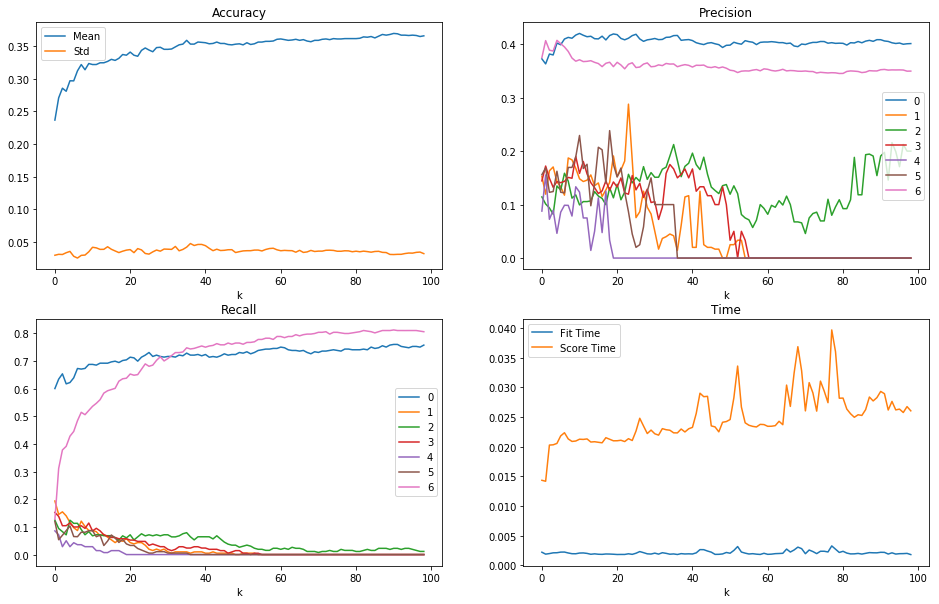

In [24]:
import warnings
warnings.filterwarnings("ignore")
Xdata_dummy = pd.get_dummies(Xdata)
### Experiment 1: k-range 2:100, algorithm = brute, weights = uniform, source
knn_test(Xdata_dummy, Ydata, weights="uniform", algorithm="brute")

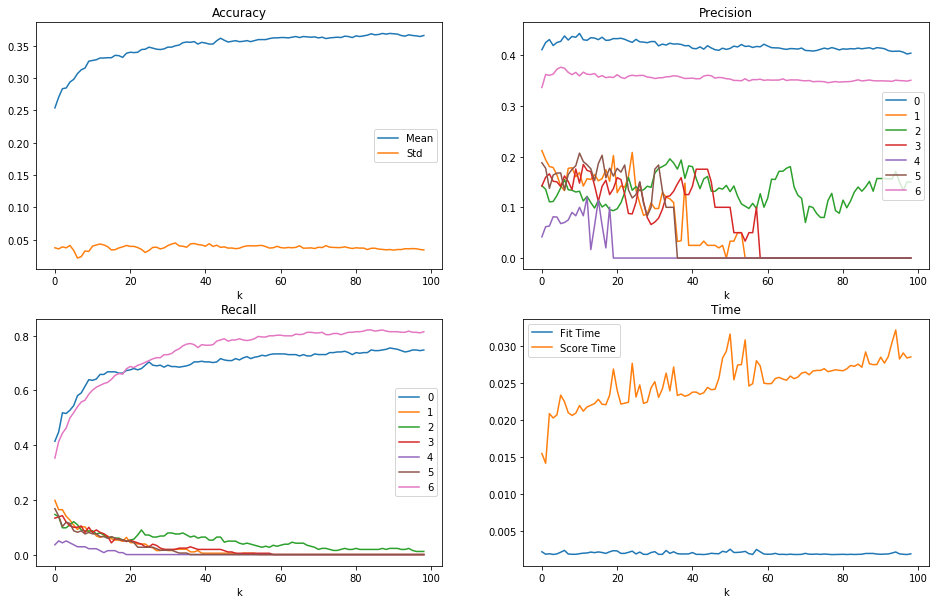

In [25]:
### Experiment 2: k-range 2:100, algorithm = brute, weights = distance, source
knn_test(Xdata_dummy, Ydata, weights="distance", algorithm="brute")

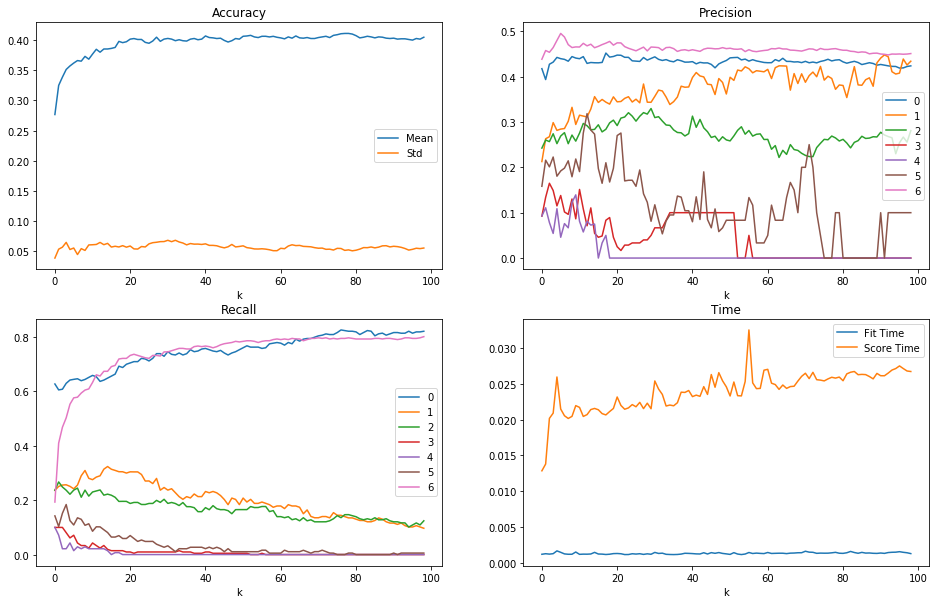

In [26]:
### dummy encoding needed to calculate distance
Xdata_dummy = pd.get_dummies(Xdata)
### scale [0, 1]
min_max_scaler = MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(Xdata_dummy)

### Experiment 3: k-range 2:100, algorithm = brute, weights = uniform, scale
knn_test(X_minmax, Ydata, weights="uniform", algorithm="brute")

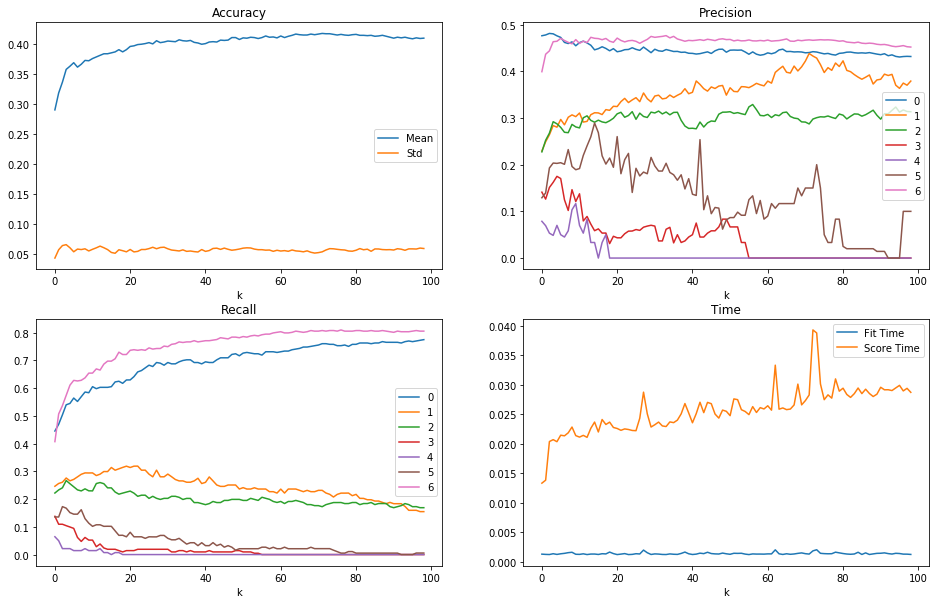

In [27]:
### dummy encoding needed to calculate distance
Xdata_dummy = pd.get_dummies(Xdata)
### scale [0, 1]
min_max_scaler = MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(Xdata_dummy)

### Experiment 4: k-range 2:100, algorithm = brute, weights = distance, scale
knn_test(X_minmax, Ydata, weights="distance", algorithm="brute")

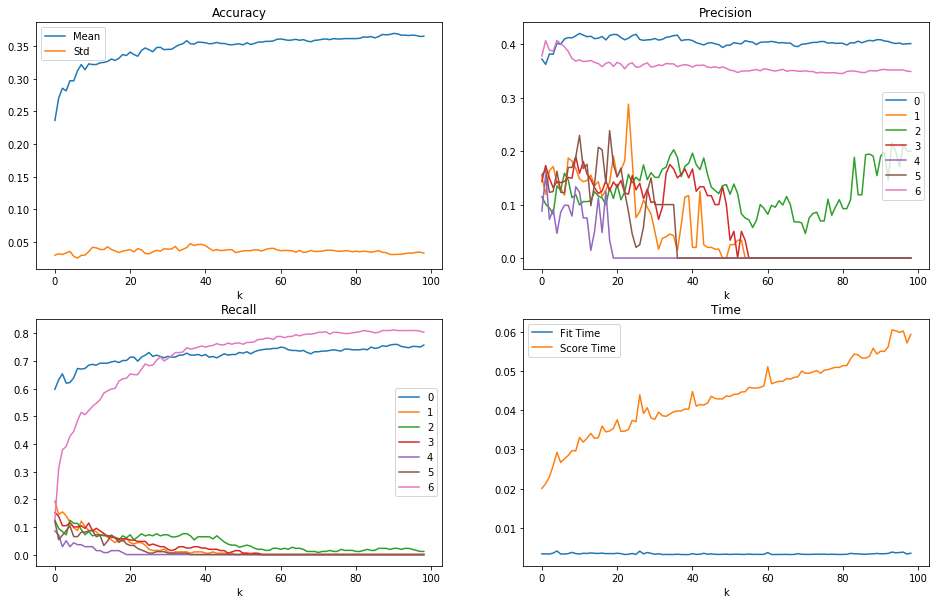

In [29]:
### dummy encoding needed to calculate distance
Xdata_dummy = pd.get_dummies(Xdata)

### Experiment 5: k-range 2:100, algorithm = kd_tree, weights = uniform, source
knn_test(Xdata_dummy, Ydata, weights="uniform", algorithm="kd_tree")

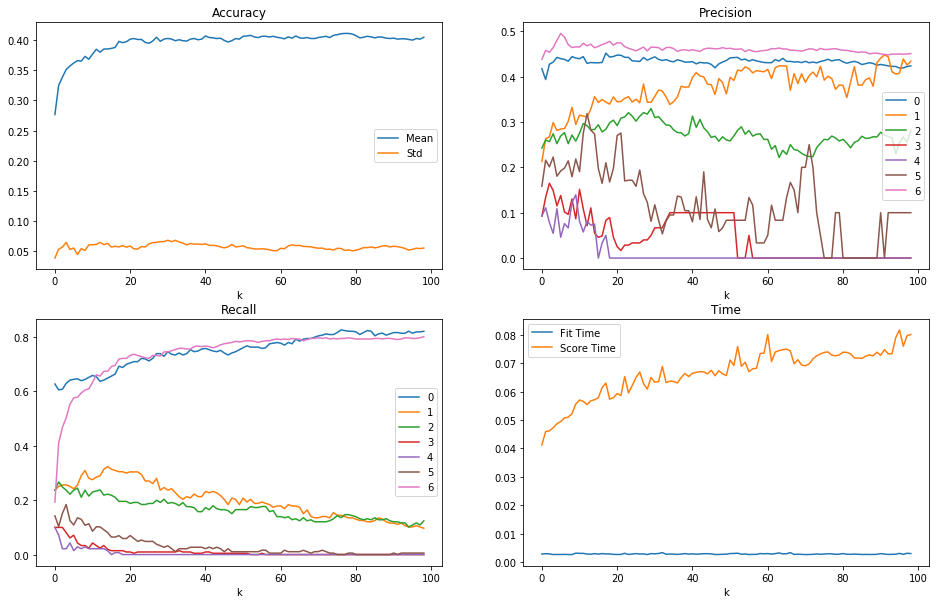

In [30]:
### dummy encoding needed to calculate distance
Xdata_dummy = pd.get_dummies(Xdata)
### scale [0, 1]
min_max_scaler = MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(Xdata_dummy)

### Experiment 6: k-range 2:100, algorithm = kd_tree, weights = uniform, scale
knn_test(X_minmax, Ydata, weights="uniform", algorithm="kd_tree")

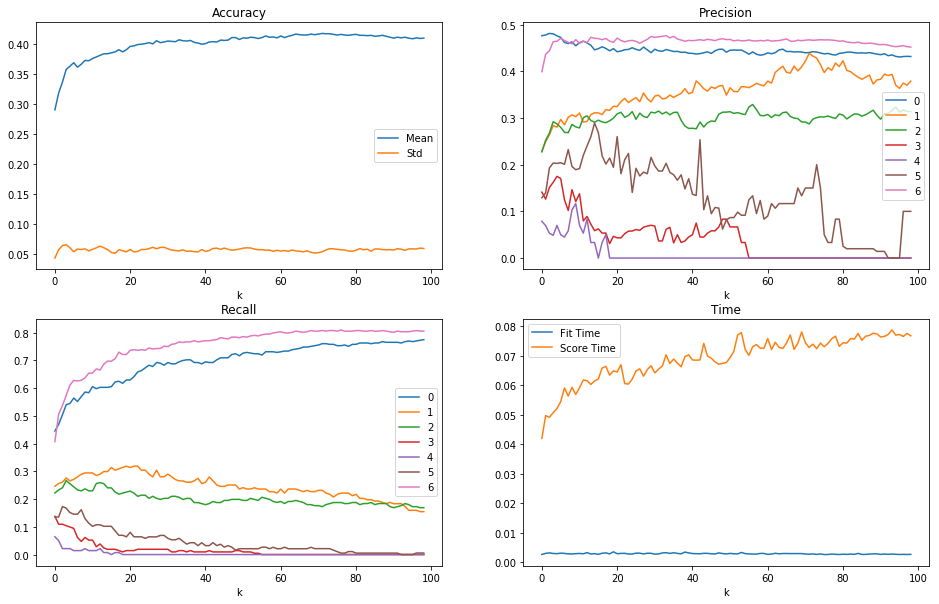

In [31]:
### dummy encoding needed to calculate distance
Xdata_dummy = pd.get_dummies(Xdata)
### scale [0, 1]
min_max_scaler = MinMaxScaler()
X_minmax = min_max_scaler.fit_transform(Xdata_dummy)

### Experiment 7: k-range 2:100, algorithm = kd_tree, weights = distance, scale
knn_test(X_minmax, Ydata, weights="distance", algorithm="kd_tree")

### Naive Bayes

In [65]:
def naive_test(classifier, Xdata, Ydata):
    precision_accumulator = []
    recall_accumulator = []
    def my_precision(y_true, y_pred, **kwargs):
        precisions = precision_score(y_true, y_pred, **kwargs)
        nonlocal precision_accumulator
        precision_accumulator.append(precisions)
        return precisions.mean()

    ### always specify a list to save results before every call
    def my_recall(y_true, y_pred, **kwargs):
        recalls = recall_score(y_true, y_pred, **kwargs)
        nonlocal recall_accumulator
        recall_accumulator.append(recalls)
        return recalls.mean()
    scoring = {"accuracy":"accuracy", "precision":make_scorer(my_precision, average=None), "recall":make_scorer(my_recall, average=None)}
    
    scores = cross_validate(classifier, Xdata, Ydata, cv=10, scoring=scoring, return_train_score=False)
       
    prec_means = get_mean(precision_accumulator)
    prec_stds = get_std(precision_accumulator)
    rec_means = get_mean(recall_accumulator)
    rec_stds = get_std(recall_accumulator)
    
    rval = {"fit_time":scores["fit_time"].mean(), "score_time":scores["score_time"].mean(), 
            "accuracy":scores["test_accuracy"].mean(), "accuracy_std":scores["test_accuracy"].std(),
            "precision_means":prec_means, "precision_std":prec_stds, "recall_means":rec_means, "recall_std":rec_stds}
    
    for i in rval:
        print(i + ":\n", rval[i])
    
    return rval

In [69]:
### numerical data is needed
Xdata = drugs.iloc[:,1:13]
Xdata_disc = Xdata

#discretize continuis variables
for i in range(5,Xdata.shape[1]):
    quantiles = Xdata.iloc[:,i].quantile([0,0.2,0.4,0.6,0.8,1])
    Xdata_disc.iloc[:,i] = pd.cut(Xdata.iloc[:,i], quantiles, include_lowest=True)

Xdata_lable = Xdata_disc    
    
for i in range(0,12):
    lable_encoder = LabelEncoder()
    Xdata_lable.iloc[:,i] = lable_encoder.fit_transform(Xdata_lable.iloc[:,i])

#scores_mnb = cross_validate(mnb, Xdata, Ydata, cv=10, scoring=scoring, return_train_score=False)
#scores_bnb = cross_validate(bnb, Xdata, Ydata, cv=10, scoring=scoring, return_train_score=False)
#scores_gnb = cross_validate(gnb, Xdata, Ydata, cv=10, scoring=scoring, return_train_score=False)

In [71]:
results = naive_test(MultinomialNB(), Xdata_lable, Ydata)

fit_time:
 0.0030611753463745117
score_time:
 0.002817583084106445
accuracy:
 0.37636537620277927
accuracy_std:
 0.0375915877579246
precision_means:
 [0.43791059175458846, 0.3416666666666667, 0.17829365079365078, 0.1738095238095238, 0.0, 0.0, 0.3805889410376499]
precision_std:
 [0.05016707534104501, 0.2642541332005618, 0.1230838479203492, 0.31427970172218894, 0.0, 0.0, 0.02806524946821996]
recall_means:
 [0.7263646922183508, 0.09666666666666666, 0.08262108262108261, 0.028138528138528136, 0.0, 0.0, 0.7807585568917669]
recall_std:
 [0.13801218876322824, 0.045525403438922356, 0.05472343761970154, 0.03937305526592281, 0.0, 0.0, 0.1272528120375808]


In [72]:
results = naive_test(BernoulliNB(), Xdata_lable, Ydata)

fit_time:
 0.002699446678161621
score_time:
 0.002878737449645996
accuracy:
 0.3640533880239434
accuracy_std:
 0.036677820012240465
precision_means:
 [0.4161194531906876, 0.16666666666666666, 0.18211171869066606, 0.21833333333333332, 0.05, 0.0, 0.38438633002127887]
precision_std:
 [0.06274423862157481, 0.32394177193585005, 0.06840371106433436, 0.14602764832070012, 0.15811388300841897, 0.0, 0.0389500408198753]
recall_means:
 [0.7018002322880371, 0.014285714285714285, 0.1198005698005698, 0.03787878787878788, 0.007142857142857143, 0.0, 0.7611933395004625]
recall_std:
 [0.11408526679081686, 0.023002185311411807, 0.059433754886685175, 0.01997527878774477, 0.02258769757263128, 0.0, 0.13729431575924614]


In [73]:
results = naive_test(GaussianNB(), Xdata_lable, Ydata)

fit_time:
 0.0028878211975097655
score_time:
 0.0033861398696899414
accuracy:
 0.36310428838592973
accuracy_std:
 0.05158832990628404
precision_means:
 [0.5118785800883178, 0.28653416246063307, 0.2287984237984238, 0.20624902874902876, 0.05333333333333333, 0.1, 0.39564132778143407]
precision_std:
 [0.08773762357784785, 0.10041192322716175, 0.13062197952973403, 0.10043644569987642, 0.11674600476945507, 0.31622776601683794, 0.03701879652783038]
recall_means:
 [0.5619628339140534, 0.36142857142857143, 0.10541310541310542, 0.14155844155844155, 0.014285714285714285, 0.005263157894736842, 0.6834875115633673]
recall_std:
 [0.12485588537601365, 0.13107882303531915, 0.06220141650071345, 0.07174634518894288, 0.03011693009684171, 0.01664356663246515, 0.13395028227656441]


### Random Forest

In [74]:
def test_rfc(Xdata, Ydata, criterion = "gini", min_samples_split = 2, min_samples_leaf = 1):
    accuracy_mean = []
    accuracy_std = []
    fit_time = []
    score_time = []
    number_of_classes = len(Ydata.unique())

    ### list for each target class
    precision_mean = [ [] for i in range(number_of_classes) ]
    precision_std = [ [] for i in range(number_of_classes) ]
    recall_mean = [ [] for i in range(number_of_classes) ]
    recall_std = [ [] for i in range(number_of_classes) ]  
    recall_accumulator = []
    precision_accumulator = []
    ### always specify a list to save results before every call
    def my_precision(y_true, y_pred, **kwargs):
        precisions = precision_score(y_true, y_pred, **kwargs)
        nonlocal precision_accumulator
        precision_accumulator.append(precisions)
        return precisions.mean()

    ### always specify a list to save results before every call
    def my_recall(y_true, y_pred, **kwargs):
        recalls = recall_score(y_true, y_pred, **kwargs)
        nonlocal recall_accumulator
        recall_accumulator.append(recalls)
        return recalls.mean()
    scoring = {"accuracy":"accuracy", "precision":make_scorer(my_precision, average=None), "recall":make_scorer(my_recall, average=None)}
 
    xaxis = []
    
    for i in range(10, 201, 10):
        xaxis.append(i)
    
    for i in range(10, 201, 10):
        rfc = RandomForestClassifier(n_estimators=i, criterion=criterion, min_samples_split=min_samples_split)
        scores = cross_validate(rfc, Xdata, Ydata, cv=10, scoring=scoring, return_train_score=False)
    
        accuracy_mean.append(scores["test_accuracy"].mean())
        accuracy_std.append(scores["test_accuracy"].std())
        fit_time.append(scores["fit_time"].mean())
        score_time.append(scores["score_time"].mean())
        
        prec_means = get_mean(precision_accumulator)
        prec_stds = get_std(precision_accumulator)
        rec_means = get_mean(recall_accumulator)
        rec_stds = get_std(recall_accumulator)
        

             
        for i in range(number_of_classes):
            precision_mean[i].append(prec_means[i])
            precision_std.append(prec_stds[i])
            recall_mean[i].append(rec_means[i])
            recall_std[i].append(rec_stds[i])

    
    #Plot
    plt.figure(figsize=(16, 10))
    plt.subplot(2,2,1)
    plt.plot(accuracy_mean)
    plt.plot(accuracy_std)
    plt.title("Accuracy")
    plt.xlabel("k")
    plt.legend(("Mean", "Std"))
    plt.subplot(2,2,2)
    for i in range(number_of_classes):
        plt.plot(precision_mean[i])
    plt.legend(sorted(Ydata.unique()))
    plt.title("Precision")
    plt.xlabel("k")
    plt.subplot(2,2,3)
    for i in range(number_of_classes):
        plt.plot(recall_mean[i])
    plt.legend(sorted(Ydata.unique()))
    plt.title("Recall")
    plt.xlabel("k")
    plt.legend(sorted(Ydata.unique()))
    plt.subplot(2,2,4)
    plt.plot(fit_time)
    plt.plot(score_time)
    plt.title("Time")
    plt.xlabel("k")
    plt.legend(("Fit Time", "Score Time"))

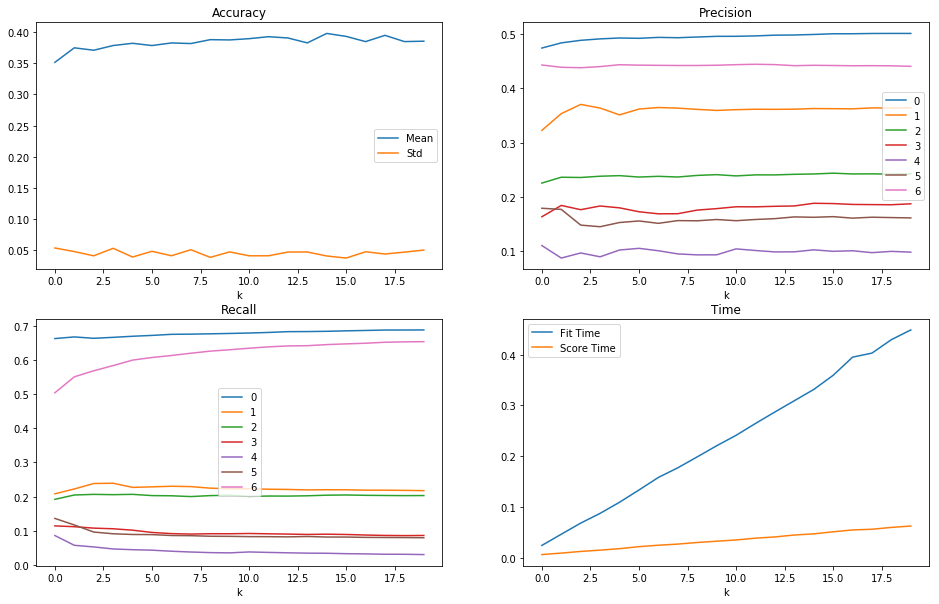

In [75]:
Xdata_lable = Xdata

for i in range(0,5):
    lable_encoder = LabelEncoder()
    Xdata_lable.iloc[:,i] = lable_encoder.fit_transform(Xdata.iloc[:,i])
    

test_rfc(Xdata_lable, Ydata, "gini", 2)

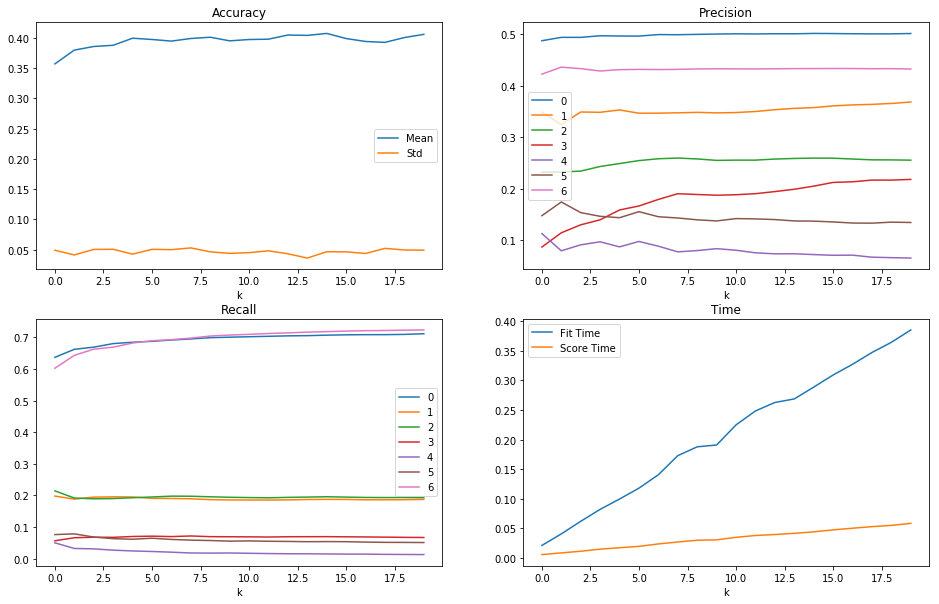

In [76]:
test_rfc(Xdata_lable, Ydata, "gini", 5)

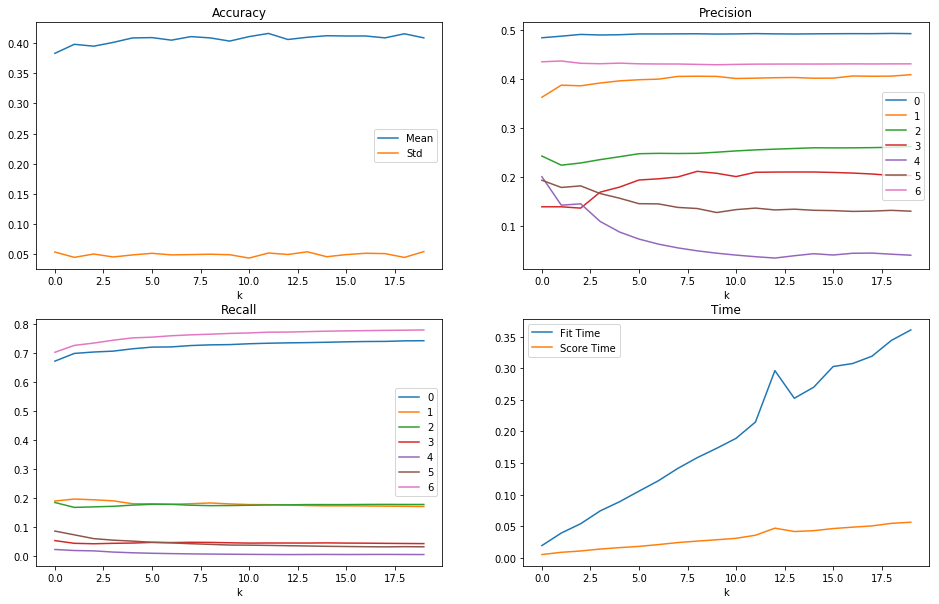

In [77]:
test_rfc(Xdata_lable, Ydata, "gini", 10)

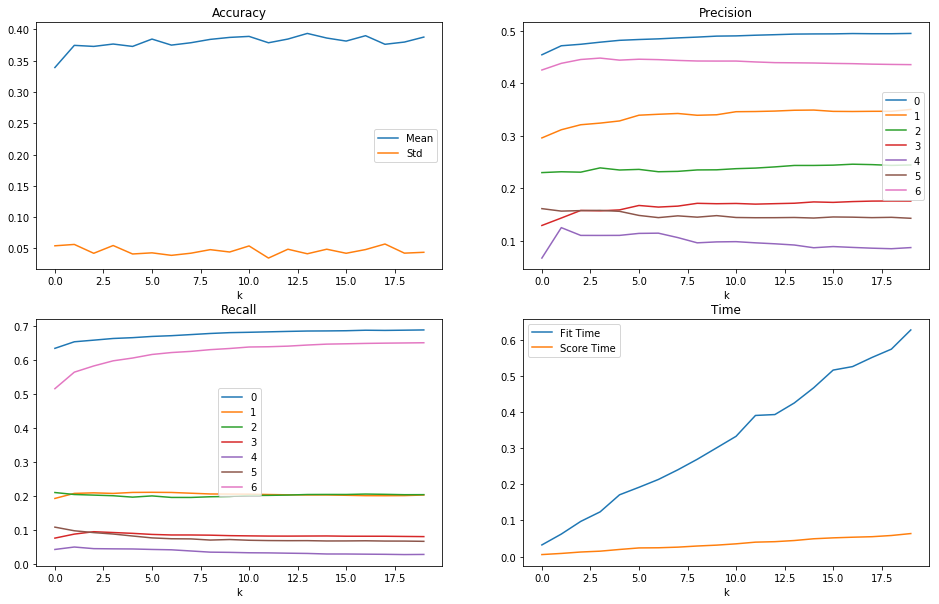

In [78]:
test_rfc(Xdata_lable, Ydata, "entropy", 2)

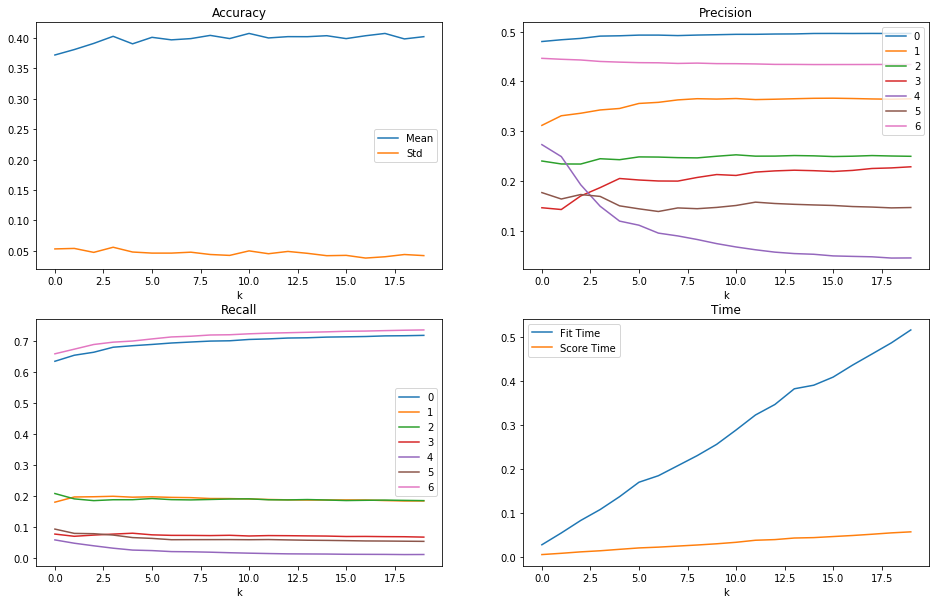

In [79]:
test_rfc(Xdata_lable, Ydata, "entropy", 5)

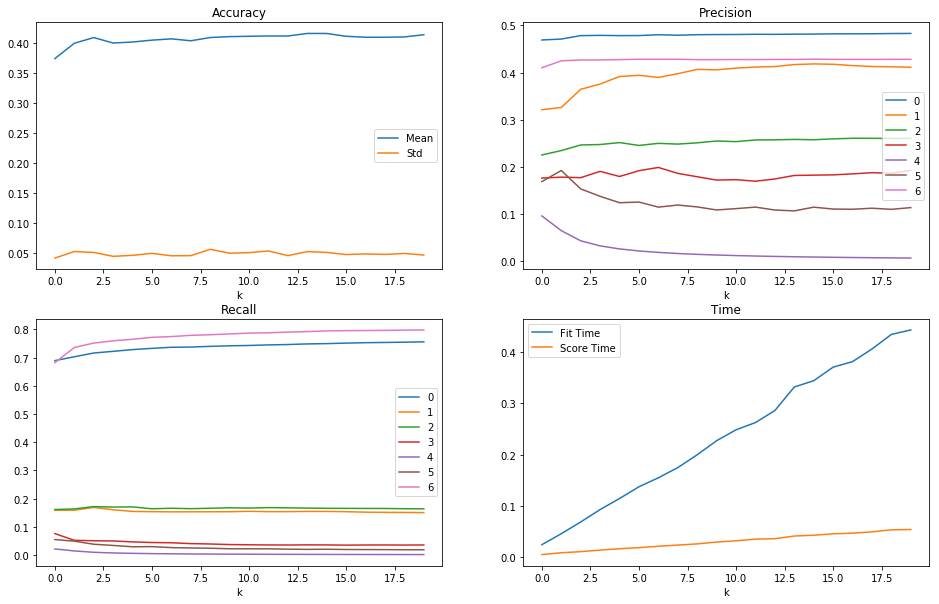

In [80]:
test_rfc(Xdata_lable, Ydata, "entropy", 10)